In [1]:
import pandas as pd
import numpy as np
import requests
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.style.use("seaborn")

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Defining Features and Classifier

In [2]:
df_all = pd.read_csv("Trees_clean.csv", index_col=False)

In [3]:
df_all.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,5,29


In [4]:
X = df_all.drop("Cover_Type",axis=1)
y = df_all["Cover_Type"]

In [5]:
#Splitting the set (test = 0.3) in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y, random_state=4444)

In [6]:
#scaling the features
sca = StandardScaler()
sca.fit_transform(X_train)
sca.transform(X_test);

In [8]:
def alg_class(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print("Accuracy_train: " + str(estimator.score(X_train, y_train)))
    print("Accuracy_test: " + str(accuracy_score(y_pred,y_test)))    

In [14]:
def plot_scores_knn(k, acc_train, acc_test):
    fig, axes = plt.subplots(1, 2, figsize=(30,6))
    axes[0].plot(k,acc_train)
    axes[0].set_xlabel("Depth")
    axes[0].set_ylabel("Accuracy train")

    axes[1].plot(k,acc_test)
    axes[1].set_xlabel("Depth")
    axes[1].set_ylabel("Recall")


### Apply bagging classifier

In [9]:
#Trying with default parameters
alg_class(BaggingClassifier(base_estimator=DecisionTreeClassifier()), X_train, y_train, X_test, y_test)

Accuracy_train: 0.9978092390609479
Accuracy_test: 0.9556808793831467


In [22]:
acc_test_d = []
acc_train_d = []
depth_ = []
for depth in range(1, 51) :
    bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=depth), n_estimators=50, n_jobs=-1)
    bg.fit(X_train, y_train)
    y_pred = bg.predict(X_test)
    acc_train_d.append(bg.score(X_train, y_train))
    acc_test_d.append(accuracy_score(y_pred,y_test))  
    depth_.append(depth)

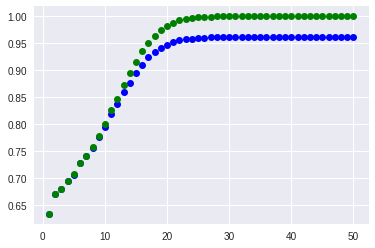

In [23]:
plt.plot(depth_,acc_test_d,"bo")
plt.plot(depth_,acc_train_d,"go")

In [24]:
acc_test_e = []
acc_train_e = []
n_estimators_ = []
for n_estimators in range(10,110,10) :
    bg = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=50), n_estimators=n_estimators, n_jobs=-1)
    bg.fit(X_train, y_train)
    y_pred = bg.predict(X_test)
    acc_train_e.append(bg.score(X_train, y_train))
    acc_test_e.append(accuracy_score(y_pred,y_test))  
    n_estimators_.append(n_estimators)

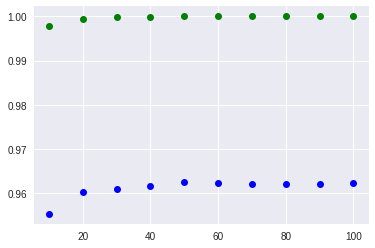

In [25]:
plt.plot(n_estimators_,acc_test_e,"bo")
plt.plot(n_estimators_,acc_train_e,"go")

In [26]:
def grid_estimator(estimator, param_grid, X_train, y_train, X_test, y_test, cv=5):
    grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv, n_jobs=1)
    grid.fit(X_train, y_train)
    print("Accuracy training: " + str(grid.best_score_))
    y_pred = grid.predict(X_test)
    print("Accuracy test: " + str(accuracy_score(y_pred,y_test)))
    print(grid.best_estimator_)

### Selecting features determined to be important by Random Forest

In [22]:
col_in = ["Elevation","Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_in = X[col_in]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]

In [ ]:
param_grid = {'max_depth': [50,100,150], 'max_leaf_nodes':[100000,1000000,10000000]}
grid_estimator(DecisionTreeClassifier(), param_grid, X_train_in, y_train, X_test_in, y_test)